In [15]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)

# Import Data

In [4]:
data = pandas.read_csv('./dataset/conversion_project.csv')

In [5]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


# Data Exploration

In [6]:
data.shape

(316200, 6)

In [8]:
data.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [9]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [10]:
data.groupby(['country']).size()

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64

In [11]:
data.groupby(['source']).size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64

A few quick observations

the site is probably a US site, although it does have a large Chinese user base as well

user base is pretty

conversion rate at around 3% is industry standard. It makes sense

everything seems to make sense here except for max age 123 yrs! Let’s investigate it:

In [12]:
print(sorted(data['age'].unique(), reverse=True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


In [13]:
data.query('age >100')

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [14]:
#remove wrong data
data = data.query('age < 100')

Now, let’s quickly investigate the variables and how their distribution differs for the two classes. This will help us understand whether there is any information in our data in the first place and get a sense of the data.


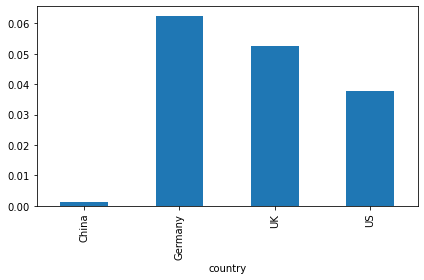

In [16]:
rcParams.update({'figure.autolayout': True})
data.groupby(['country'])['converted'].mean().plot.bar()

Here it clearly looks like Chinese convert at a much lower rate than other countries!

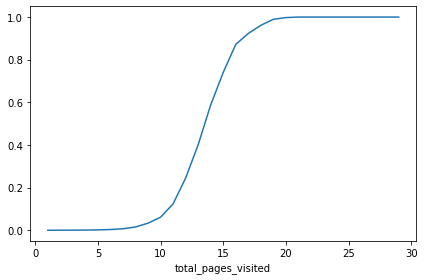

In [17]:
data.groupby(['total_pages_visited'])['converted'].mean().plot()

Definitely spending more time on the site implies higher probability of conversion!

I am going to pick a random forest to predict conversion rate. I picked a random forest because: it usually requires very little time to optimize it (its default params are often close to be the best ones) and it is strong with outliers, irrelevant variables, continuous and discrete variables.

# Model Building

In [18]:
#dummy variables for the categorical ones
data_dummy = pd.get_dummies(data, drop_first=True)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from numpy.core.umath_tests import inner1d
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)

In [20]:
#split into train and test to avoid overfitting
train, test = train_test_split(data_dummy, test_size = 0.34)

In [21]:
data_dummy.head()

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1


In [22]:
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('converted', axis=1), train['converted'])

RandomForestClassifier(max_features=3, oob_score=True)

In [23]:
#let's print OOB accuracy and confusion matrix
print("OOB accuracy is", rf.oob_score_, "\n", "OOB Confusion Matrix", "\n",pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9838851885571901 
 OOB Confusion Matrix 
         0     1
0  200872  1102
1    2261  4455


In [24]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('converted', axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9847360196450496 
 Test Set Confusion Matrix 
         0     1
0  103483   543
1    1098  2384


So, OOB error and test error are pretty similar, ~1.5%. We are confident we are not overfitting.

Error is pretty low. However, we started from a 97% accuracy (that’s the case if we classified everything as a “non converted”). So, 98.5% is good, but nothing shocking. Indeed, ~30% of conversions are predicted as “non conversion”.

If we cared about the very best possible accuracy or specifically minimizing false positive/false negative, we would find the best cut-off point. Since in this case that doesn’t appear to be particularly relevant, we are fine with the default 0.5 cutoff value used internally by the random forest to make the prediction.

If you care about insights, building a model is just the first step. You need to check that the model predicts well and, if it does, you can now extract insights out of it.

Let’s start by checking variable importance:

In [29]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)

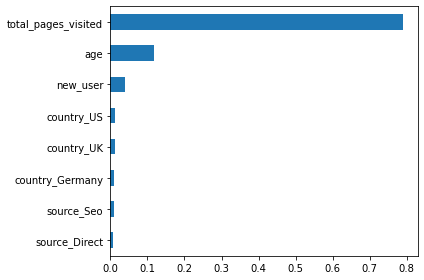

In [30]:
feat_importances.sort_values().plot(kind='barh')

Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”. People visit many pages because they already want to buy. Also, in order to buy, you have to click on multiple pages. Let’s rebuild the RF without that variable. Since classes are heavily unbalanced and we don’t have that very powerful variable anymore, let’s change the weights, just to make sure we will get something classified as 1.

In [31]:
#build the model without total_pages_visited
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_features=3,
                       oob_score=True)

In [32]:
#Out Of Bag Error is described as the fraction of number incorrect classifications over number of out of bag samples.
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.889827016148354 
 OOB Confusion Matrix 
         0      1
0  182720  19254
1    3738   2978


In [33]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8899802805372623 
 Test Set Confusion Matrix 
        0     1
0  94140  9886
1   1942  1540


Accuracy went down, but that’s fine. The model is still good enough to give us insights.

Let’s recheck variable importance:

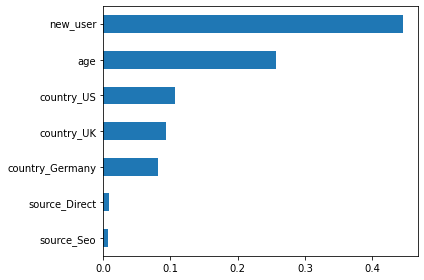

In [34]:
feat_importances = pandas.Series(rf.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances.sort_values().plot(kind='barh')

Interesting! New user is the most important one, even more important than age. And that’s impressive given that we know how continuous variables tend to always show up at the top in RF variable importance plots. It means new_user is really important. Source-related dummies don’t seem to matter at all.

Let’s check partial dependence plots for the 4 vars:

In [35]:
from pdpbox import pdp, info_plots

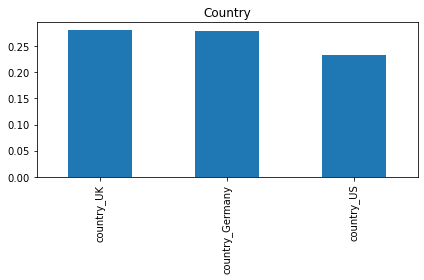

In [36]:
#country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')

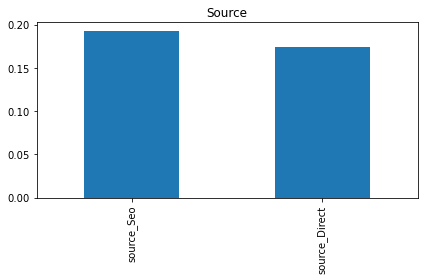

In [38]:
#source
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')

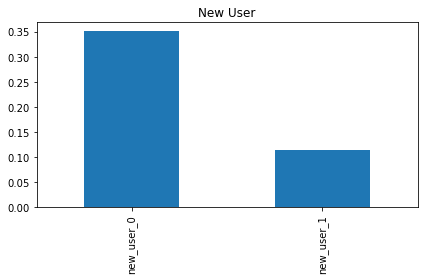

In [39]:
#new user
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')

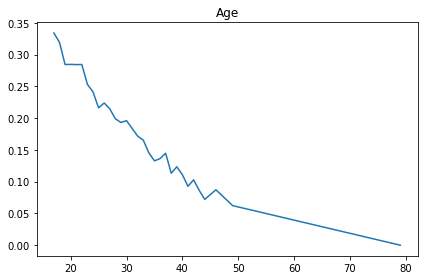

In [40]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')

This shows that:

Users with an old account are much better than new users

Germany, UK, and US are similar, with Germany being the best. Most importantly, they all have very very high values. As usual, we have to read this as relative to the reference level, which is China. So this means that not being from China and being from any of those 3 countries significantly increases the probability of conversion. That is, China is very bad for conversion

The site works very well for young people and gets worse for >30 yr old

Source is less relevant


Let’s now build a simple decision tree and check the 2 or 3 most important segments:

In [41]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#visualize it
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_conversion.dot")
s.view()

'tree_conversion.dot.pdf'

# Insights

A simple small tree confirms exactly the random forest findings.

Conclusions and next steps:

The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people,

The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.

Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity.

As we can see, product ideas usually end up being about:

Identify segments that perform well, but have low absolute count (like Germany). Then tell marketing to get more of those people

Tell product to fix the experience for the bad performing ones

Bad performing segments with high absolute count (like China) usually provide the biggest opportunities for massive gains, if we can guess why that’s happening and then build a test to validate our hypothesis